# CSCI 3202, Spring 2024: Final Practicum

---


This practicum is due on Gradescope by **12:00 PM (NOON) on Sunday May 5**.  Your solutions to theoretical questions should be done in Markdown/LateX directly below the associated question. Your solutions to computational questions should include any relevant Python code, as well as results and any written commentary.


1. All work, code and analysis must be **your own**.
1. You may use your course notes, posted lecture slides, textbook, in-class notebooks and homework solutions as resources.  You may also search online for answers to general knowledge questions, like the form of a probability distribution function, or how to perform a particular operation in Python.
1. You may **not** post to message boards or other online resources asking for help.
1. **You may not collaborate with classmates or anyone else.**
1. This is meant to be like a coding portion of your final exam. So, I will be much less helpful than I typically am with homework. For example, I will not check answers, help debug your code, and so on.
1. If you have a question, post it first as a **private** Piazza message. If I decide that it is appropriate for the entire class, then I will make it a public post (and anonymous).
1. If something is left open-ended, it is probably because I intend for you to code it up however you want, and only care about the plots/analysis I see at the end. Feel free to ask clarifying questions though.

Violation of these rules will result in an **F** and a trip to the Honor Code council.

---
**By writing your name below, you agree to abide by these rules:**

**Your name:** Andrew Logue

---



In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# added packages
import heapq
from matplotlib import colors



---
## [100 pts] Problem 1:  Reinforcement learning

Consider a **cube** state space defined by $0 \le x, y, z \le L$. Suppose you are piloting/programming a drone to learn how to land on a platform at the center of the $z=0$ surface (the bottom). Some assumptions:
* In this discrete world, if I say the drone is at $(x,y,z)$ I mean that it is in the box centered at $(x,y,z)$. And there are boxes (states) centered at $(x,y,z)$ for all $0 \le x,y,z \le L$. Each state is a 1 unit cube. So when $L=2$ (for example), there are cubes centered at each $x=0,1,2$, $y=0,1,2$ and so on, for a total state space size of $3^3 = 27$ states.
* All of the states with $z=0$ are terminal states.
* The state at the center of the bottom of the cubic state space is the landing pad. So, for example, when $L=4$, the landing pad is at $(x,y,z) = (2,2,0)$.
* All terminal states ***except*** the landing pad have a reward of -1. The landing pad has a reward of +1.
* All non-terminal states have a reward of -0.01.
* The drone takes up exactly 1 cubic unit, and begins in a random non-terminal state.
* The available actions in non-terminal states include moving exactly 1 unit Up (+z), Down (-z), North (+y), South (-y), East (+x) or West (-x). In a terminal state, the training episode should end.

#### Part A
Write a class `MDPLanding` to represent the Markov decision process for this drone. Include methods for:
1. `actions(state)`, which should return a list of all actions available from the given state
2. `reward(state)`, which should return the reward for the given state
3. `result(state, action)`, which should return the resulting state of doing the given action in the given state

and attributes for:
1. `states`, which is just a list of all the states in the state space, where each state is represented as an $(x,y,z)$ tuple
2. `terminal_states`, a dictionary where keys are the terminal state tuples and the values are the rewards associated with those terminal states
3. `default_reward`, which is a scalar for the reward associated with non-terminal states
4. `all_actions`, a list of all possible actions (Up, Down, North, South, East, West)
5. `discount`, the discount factor (use $\gamma = 0.999$ for this entire problem)

How you feed arguments/information into the class constructor is up to you.

Note that actions are *deterministic* here.  The drone does not need to learn transition probabilities for outcomes of particular actions. What the drone does need to learn, however, is where the heck that landing pad is, and how to get there from any initial state.

In [2]:
class MDPLanding:    
    def __init__(self, L):
        'Create attributes'
        self.L = L
        self.states = [(x, y, z) for x in range(L+1) for y in range(L+1) for z in range(L+1)]
        self.terminal_states = {}
        for i in self.states:
            if i[2] == 0:
                if (i[0] == L//2 and i[1] == L//2):
                    self.terminal_states[i] = 1
                else:
                    self.terminal_states[i] = -1
        self.default_reward = -0.01
        self.all_actions = ['Up', 'Down', 'North', 'South', 'East', 'West']
        self.discount = 0.999

    def actions(self, state):
        'return a list of all actions available from the given state'
        x, y, z = state
        actions = []
        if z != self.L:
            actions.append(self.all_actions[0])
        if z != 0:
            actions.append(self.all_actions[1])
        if y != self.L:
            actions.append(self.all_actions[2])
        if y != 0:
            actions.append(self.all_actions[3])
        if x != self.L:
            actions.append(self.all_actions[4])
        if x != 0:
            actions.append(self.all_actions[5])
            
        return actions

    def reward(self, state):
        'return the reward for the given state'
        if state in self.terminal_states:
            return self.terminal_states.get(state)
        else:
            return self.default_reward
        
        
    def result(self, state, action):
        'return the resulting state of doing the given action in the given state'
        x, y, z = state
        if action not in self.actions(state):
            return state
        elif action == 'Up':
            return (x, y, z+1)
        elif action == 'Down':
            return (x, y, z-1)
        elif action == 'North':
            return (x, y+1, z)
        elif action == 'South':
            return (x, y-1, z)
        elif action == 'East':
            return (x+1, y, z)
        elif action == 'West':
            return (x-1, y, z)


#### Part B
Write a function to implement **policy iteration** for this drone landing MDP. Create an MDP environment to represent the $L=4$ case (so 125 total states).

Use your function to find an optimal policy for your new MDP environment. Check (by printing to screen) that the policy for the following states are what you expect, and comment on the results:
1. $(2,2,1)$
1. $(0,2,1)$
1. $(2,0,1)$

In [3]:
def policy_iteration(MDP):
    # Initialize utility for all states
    utility = {state: 0 for state in MDP.states}
    
    # Initialize a policy for each state, being a random action
    policy = {state: random.choice(MDP.actions(state)) for state in MDP.states}
    
    # iterate:
    for _ in range(5):
        # update utility, using policy_evaluation and current estimates of utility and policy
        utility = policy_evaluation(policy, utility, MDP, n_iter=5)
        # initialize unchnaged = True
        unchnaged = True
        
        # for each state s:
        for s in MDP.states:
            # among the possible actions, which yields the maximum expected utility?
            max_utility = -999
            best_action = None
            for action in MDP.actions(s):
                action_utility = sum((next_state == MDP.result(s, action)) * utility[next_state] for next_state in MDP.states)
                if action_utility > max_utility:
                    max_utility = action_utility
                    best_action = action
            # if the best action choice is not currently the policy for s, update it
            if best_action != policy[s]:
                policy[s] = best_action
                unchanged = False
            
        # if no policy values are changed, break!
        if unchanged:
            break
    # final policy
    return policy

def policy_evaluation(policy, utility, MDP, n_iter):
    # do a handful of value iteration updates of the input utility, under the given policy
    for _ in range(n_iter):
        updated_utility = {}
        for s in MDP.states:
            updated_utility[s] = MDP.reward(s) + MDP.discount * sum((next_state == MDP.result(s, policy[s])) * utility[next_state] for next_state in MDP.states)
        utility = updated_utility
    # updated utility
    return utility

# Create an MDP environment for L=4
MDP = MDPLanding(4)

# Perform policy iteration
policy = policy_iteration(MDP)
print("Policy for state (2,2,1):", policy[(2,2,1)])
print("Policy for state (0,2,1):", policy[(0,2,1)])
print("Policy for state (2,0,1):", policy[(2,0,1)])

Policy for state (2,2,1): Down
Policy for state (0,2,1): East
Policy for state (2,0,1): North


The policy for the states make sense, given that the landing pad is located at (2,2,0). For the state (2,2,1), directly above the landing pad, the policy is for the drone to move down (z-1). For the state (0,2,1), the policy is for the drone to move East towards the landing pad (x+1). For the state (2,0,1), the policy is for the drone to move North towards the landing pad (y+1). Based on these values we can assume that our policy is optimized.

#### Part C

Code up a **Q-learning** agent/algorithm to learn how to land the drone. You can do this however you like, as long as you use the MDP class structure defined above.  

Your code should include some kind of a wrapper to run many trials to train the agent and learn the Q values (see Section 22.3 in the textbook - page 803 might be of particular interest).  You also do not need to have a separate function for the actual "agent"; your code can just be a "for" loop within which you are refining your estimate of the Q values.

From each training trial, save the cumulative discounted reward (utility) over the course of that episode. That is, add up all of $\gamma^t R(s_t)$ where the drone is in state $s_t$ during time step $t$, for the entire sequence. I refer to this as "cumulative reward" because we usually refer to "utility" as the utility *under an optimal policy*.

Some guidelines:
* The drone should initialize in a random non-terminal state for each new training episode.
* The training episodes should be limited to 50 time steps, even if the drone has not yet landed. If the drone lands (in a terminal state), the training episode is over.
* You may use whatever learning rate $\alpha$ you decide is appropriate, and gives good results.
* There are many forms of Q-learning. You can use whatever you would like, subject to the reliability targets in Part D below.
* Your code should return:
  * The learned Q values associated with each state-action pair.
  * The cumulative reward for each training trial. 
  * Anything else that might be useful in the ensuing analysis.

In [4]:
def QLearning(MDP, num_trials):
    # Define training parameters
    epsilon = 0.9  # Rate at which the best learned actio is chosen
    learning_rate = 0.9
    # Initialize variables
    nonterminal_states = [s for s in MDP.states if s[2] != 0]
    cumulative_rewards = []
    q_values = np.zeros((MDP.L+1, MDP.L+1, MDP.L+1, len(MDP.all_actions)))

    for trial in range(num_trials):
        # Initialize variables for each trial
        cumulative_reward = 0
        time_step = 0
        current_state = random.choice(nonterminal_states)

        # Continue taking actions until a terminal state is reached, or 50 actions have been taken
        while current_state not in MDP.terminal_states and time_step < 50:
            time_step += 1
            
            # Get next action (index)
            if np.random.random() < epsilon:
                action_index = np.argmax(q_values[current_state])
            else:
                action_index = np.random.randint(len(MDP.all_actions))
            action = MDP.all_actions[action_index]

            # Save old state and perform action
            old_state = current_state
            current_state = MDP.result(old_state, action)
            
            # Get reward from action and add to cumulative reward
            reward = MDP.reward(current_state)
            cumulative_reward += reward
            
            # Calculate q_value
            old_q_value = q_values[old_state + (action_index,)]  # Use action_index to index properly
            max_q_value = np.max(q_values[current_state])
            temporal_difference = reward + (MDP.discount * max_q_value) - old_q_value

            # Update q_value
            new_q_value = old_q_value + (learning_rate * temporal_difference)
            q_values[old_state + (action_index,)] = new_q_value

        # Append cumulative reward
        cumulative_rewards.append(cumulative_reward)

    return q_values, cumulative_rewards
    

#### Part D

Initialize the $L=10$ environment (so that the landing pad is at $(5,5,0)$). Run some number of training trials to train the drone.

**How do I know if my drone is learned enough?**  If you take the mean cumulative reward across the last 5000 training trials, it should be around 0.80. This means at least about 10,000 (but probably more) training episodes will be necessary. It will take a few seconds on your computer, so start small to test your codes.

**Then:** Compute block means of cumulative reward from all of your training trials. Use blocks of 500 training trials. This means you need to create some kind of array-like structure such that its first element is the mean of the first 500 trials' cumulative rewards; its second element is the mean of the 501-1000th trials' cumulative rewards; and so on. Make a plot of the block mean rewards as the training progresses. It should increase from about -0.5 initially to somewhere around +0.8.

**And:** Print to the screen the mean of the last 5000 trials' cumulative rewards, to verify that it is indeed about 0.80.

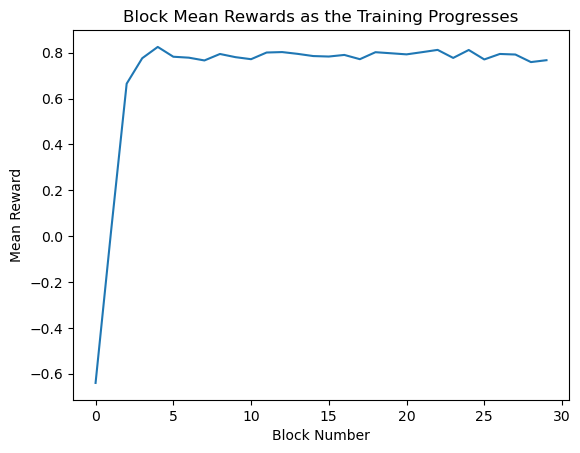

Mean of the last 5000 trials cumulative rewards: 0.78813


In [5]:
# Initialize the L=10 environment
MDP = MDPLanding(10)

# Run 5000 training trials
q_values, cumulative_rewards = QLearning(MDP, 15000)  # Adjust the number of episodes as needed

# Compute block means of cumulative rewards
block_rewards = [np.mean(cumulative_rewards[i:i+500]) for i in range(0, len(cumulative_rewards), 500)]

# Plot block mean rewards
plt.plot(block_rewards)
plt.xlabel('Block Number')
plt.ylabel('Mean Reward')
plt.title('Block Mean Rewards as the Training Progresses')
plt.show()

# Compute mean of the last 5000 trials' cumulative rewards
mean_last_5000_trials = np.mean(cumulative_rewards[-5000:])
print("Mean of the last 5000 trials cumulative rewards:", mean_last_5000_trials)

#### Part E

**Question 1:** Why does the cumulative reward start off around -0.5 at the beginning of the training?

**Question 2:** Why will it be difficult for us to train the drone to reliably obtain rewards much greater than about 0.8?

**Question 1:** The cumulative reward initialy starts off at around -0.5 becuase early in the training random actions are chosen, as the drone does not yet know which actions are optimal. This results in a reward of approximatley -0.5.

**Question 2:** It be difficult for us to train the drone to reliably obtain rewards much greater than about 0.8 because of the size of the state space, and the forced randomness of the chosen actions. If in later trials the rate of exploration was reduced, we might be able to approach a higher reward.